# エントロピー/KLダイバージェンス/交差エントロピー/自己相互情報量のPython実装

ソースコードはパフォーマンスよりもやっていることの分かりやすさを重視した書き方を心掛けました。

## 準備

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns

In [2]:
def plot_bar_graph(prob_distro):
    """確率分布の棒グラフを描画"""
    sns.barplot(x=list(prob_distro.keys()), y=list(prob_distro.values()))

In [3]:
# 確率分布A
prob_distro_a = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
# 確率分布B
prob_distro_b = {0: 0.25, 1: 0.4, 2: 0.2, 3: 0.15}
# 確率分布C
prob_distro_c = {0: 0.2, 1: 0.1, 2: 0.6, 3: 0.1}

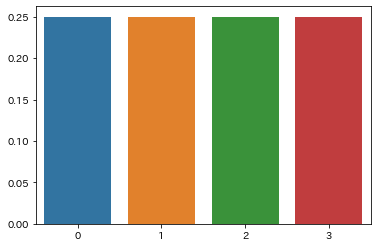

In [4]:
plot_bar_graph(prob_distro_a)

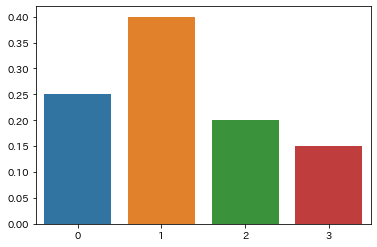

In [5]:
plot_bar_graph(prob_distro_b)

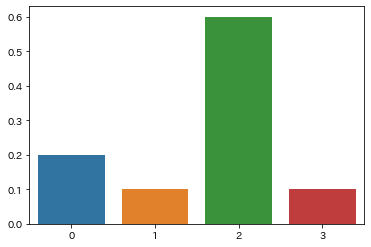

In [6]:
plot_bar_graph(prob_distro_c)

## エントロピー

確率分布に含まれる値ごとの確率の異なり度合いを表す。確率変数の実現値が何になるのかの予測しにくさ。

- 各実現値が同じような確率値をもっている（分布が一様に近い）→エントロピー大
- 各実現値の確率値がばらばら→エントロピー小

In [7]:
def calc_entropy(prob_distro):
    """エントロピーを計算"""
    result = 0
    for prob in prob_distro.values():
        # probが0のときはnp.log2(prob)が-infになってしまうので無視する（H(0)≡0として扱っているのと同義）
        if prob == 0:
            continue
        result += - prob * np.log2(prob)
    return result

In [8]:
# 分布が一様なAはエントロピーが大きい
calc_entropy(prob_distro_a)

2.0

In [9]:
calc_entropy(prob_distro_b)

1.9037016960573483

In [10]:
# 各確率の異なりの大きい分布Cはエントロピーが小さい
calc_entropy(prob_distro_c)

1.5709505944546687

In [11]:
# ちなみにscipyにエントロピーを計算する関数がある
sp.stats.entropy(list(prob_distro_c.values()), base=2)

1.5709505944546687

## KLダイバージェンス
二つの確率分布に対して、それらの異なり度合いを表す。

- 二つの分布の異なりが大きい→KLダイバージェンス大
- 異なりが小さい→KLダイバージェンス小

In [12]:
def calc_kl_div(prob_distro_1, prob_distro_2):
    """KLダイバージェンスを計算"""
    result = 0
    for prob1, prob2 in zip(prob_distro_1.values(), prob_distro_2.values()):
        # prob2に0が含まれる場合、KLダイバージェンスは定義より計算できない→スムージングで例外対応することは可能
        # https://mathoverflow.net/questions/72668/how-to-compute-kl-divergence-when-pmf-contains-0s
        if prob2 == 0:
            raise AssertionError("KL divergence can't handle zeros.")
        result += prob1 * np.log2(prob1 / prob2)
    return result

In [13]:
# 分布が一致するとKLダイバージェンスは0
calc_kl_div(prob_distro_a, prob_distro_a)

0.0

In [14]:
calc_kl_div(prob_distro_a, prob_distro_b)

0.09520544598523274

In [15]:
# 分布Aから見た分布Bは、分布Aから見た分布CよりもKLダイバージェンス（異なり）が小さい
calc_kl_div(prob_distro_a, prob_distro_c)

0.42568746970707333

## 交差エントロピー

二つの確率分布P(x), Q(x)の異なり度合いに加えて、P(x)自体のエントロピーを考慮。

確率分布Pと分布Qの交差エントロピー＝分布Pのエントロピー＋分布Pから見たQのKLダイバージェンス

- P(x)の乱雑さが大きく、かつP(x)から見てQ(x)との分布の異なりが小さい→交差エントロピーが小さい
- P(x)が一様に近く、かつP(x)から見てQ(x)との分布の異なりが大きい→交差エントロピーが大きい

In [16]:
def calc_cross_entropy(prob_distro_1, prob_distro_2):
    """交差エントロピーを計算"""
    result_intermediate = 0
    for prob1, prob2 in zip(prob_distro_1.values(), prob_distro_2.values()):
        if prob2 == 0:
            # np.log2(0)=0として扱ってるのと同義
            continue
        result_intermediate += prob1 * np.log2(prob2)
    return -result_intermediate

In [17]:
# 分布Aのエントロピーに等しい
calc_cross_entropy(prob_distro_a, prob_distro_a)

2.0

In [18]:
calc_cross_entropy(prob_distro_a, prob_distro_b)

2.0952054459852327

In [19]:
# 分布A（一様）かつ分布A、Cは異なりが大きい→交差エントロピー最大
calc_cross_entropy(prob_distro_a, prob_distro_c)

2.425687469707073

In [20]:
# 分布Aと分布Bの交差エントロピー＝分布Aのエントロピー＋分布Aから見たBのKLダイバージェンスの和
calc_cross_entropy(prob_distro_a, prob_distro_b) == calc_entropy(prob_distro_a) + calc_kl_div(prob_distro_a, prob_distro_b)

True

## 自己相互情報量

二つの確率変数の実現値x,yに対して、その共起（関連）度合いを表す。
ただし、確率変数X,Yの同時分布が既知である必要がある。

- PMIが正（P(x,y)>P(x)P(y)）：x,yが共起しやすい
- PMIが負の場合（P(x,y)<P(x)P(y)）：x,yが共起しにくい
- PMIが0の場合（P(x,y)=P(x)P(y)）：x,yは共起性なし

PMIの絶対値が大きいほど傾向が強い

In [21]:
# X,Yの同時確率分布
joint_prob_distro_xy = {
    0: {0: 0.05, 1: 0.10, 2: 0.10, 3:0.05},
    1: {0: 0.05, 1: 0.05, 2: 0.05, 3:0.05},
    2: {0: 0.01, 1: 0.02, 2: 0.04, 3:0.03},
    3: {0: 0.05, 1: 0.05, 2: 0.20, 3:0.10},
}

# 同時分布の中身の合計が1になってるか確認
sum([sum(prob_distro.values()) for prob_distro in joint_prob_distro_xy.values()]) == 1.0

True

In [22]:
def calc_pmi(x, y, prob_distro_x, prob_distro_y, joint_prob_distro_xy):
    """自己相互情報量を計算"""
    return np.log2(joint_prob_distro_xy[x][y] / (prob_distro_x[x] * prob_distro_y[y]))

In [23]:
# 参考
# prob_distro_a = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
# prob_distro_b = {0: 0.25, 1: 0.4, 2: 0.2, 3: 0.15}

In [24]:
calc_pmi(0, 1, prob_distro_a, prob_distro_b, joint_prob_distro_xy)  # log2(0.1/(0.25*0.4))=log2(1)

0.0

In [25]:
calc_pmi(3, 2, prob_distro_a, prob_distro_b, joint_prob_distro_xy)  # log2(0.2/(0.25*0.2))=log2(4)

2.0

In [26]:
calc_pmi(2, 0, prob_distro_a, prob_distro_b, joint_prob_distro_xy)  # log2(0.01/(0.25*0.25))=log2(0.16)

-2.643856189774725